In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

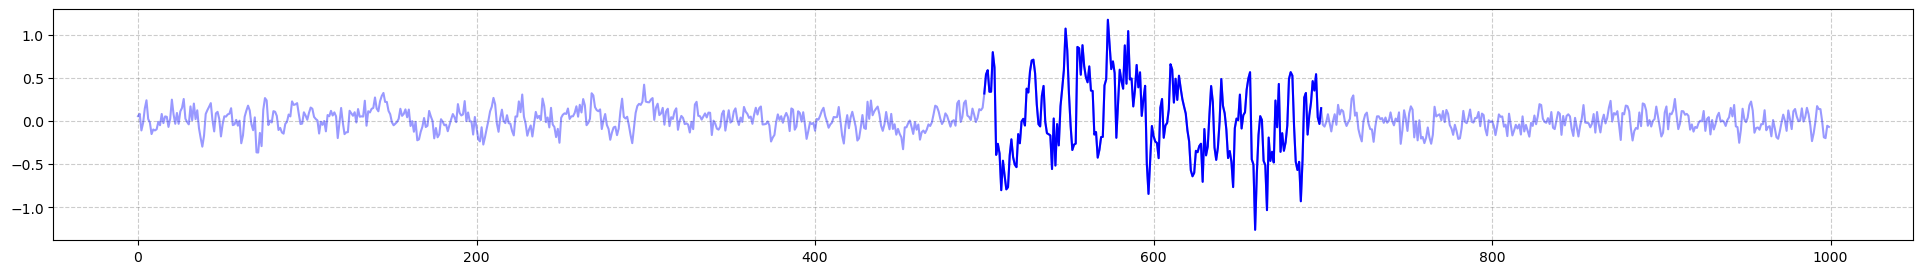

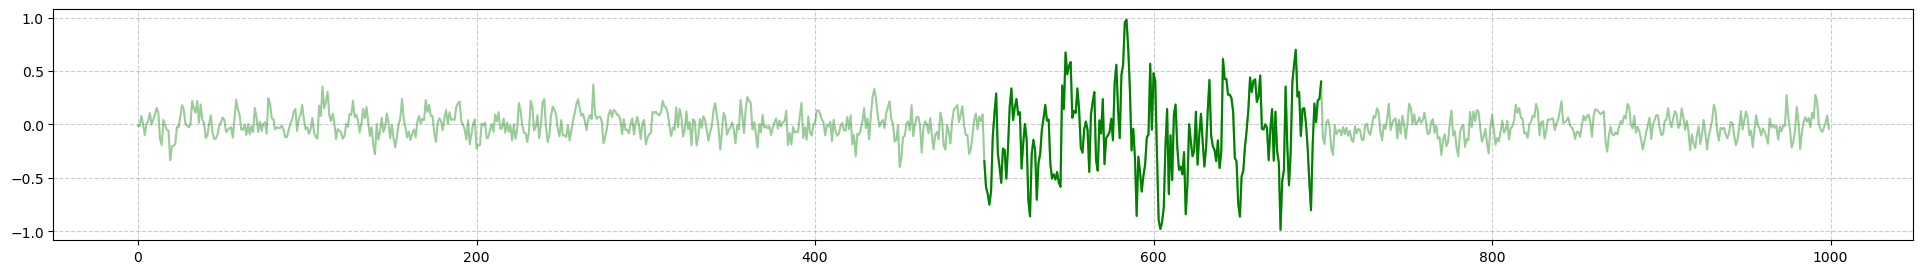

In [4]:
def data_gen(std, n_normal, n_abnormal, n_back):
    e = np.random.normal(0, std, size = (n_normal, ))
    res = [e[0]]
    for i in range(n_normal -1):
        res += [res[-1]*0.5 + e[i]]
        
    e = np.random.normal(0, std + 0.2, size = (n_abnormal, ))
    ab_res = [e[0]]
    for i in range(n_abnormal-1):
        ab_res += [ab_res[-1]*0.7 + e[i]]
    res += ab_res

    e = np.random.normal(0, std, size = (n_back, ))
    n_res = [e[0]]
    for i in range(n_back-1):
        n_res += [n_res[-1]*0.5 + e[i]]
    res += n_res
    
    return np.array(res)
arr = data_gen(0.1, 500, 200, 300)
vals = data_gen(0.1, 500, 200, 300)
plt.figure(figsize = (24, 3))
plt.plot(arr, color = "blue", alpha = .4)
plt.plot(np.arange(500, 700), arr[500:700], color = "blue")
plt.grid(linestyle = "--", color = "gray", alpha = .4)
plt.show()
plt.figure(figsize = (24, 3))
plt.plot(vals, color = "green", alpha = .4)
plt.plot(np.arange(500, 700), vals[500:700], color = "green")
plt.grid(linestyle = "--", color = "gray", alpha = .4)
plt.show()

In [5]:
def time_preprocessing(arr, p):
    res = list()
    for i in range(arr.shape[0] - p):
        res += [list(arr[i:i+p])]
    return np.array(res).reshape(-1, p)
    
def preprocessing(arr, p, q):
    from scipy.stats import kurtosis
    arr = time_preprocessing(arr, p+q)
    res = [list() for i in range(5)]
    for i in range(p):
        temp = arr[:, i:i+q]
        res[0] += [np.min(temp, axis = 1)]
        res[1] += [np.max(temp, axis = 1)]
        res[2] += [kurtosis(temp, fisher = False, axis = 1)]
        res[3] += [np.mean(temp, axis = 1)]
        res[4] += [np.std(temp, axis = 1)]
    res = np.array(res).reshape(arr.shape[0], p, 5)
    out = np.zeros(shape = (arr.shape[0], p, 6))
    out[:, :, 0] = arr[:, q:]
    for i in range(5):
        out[:, :, i+1] = res[:, :, i]
    return out

In [6]:
class Encoder(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers):
        super(Encoder, self).__init__()
        # LSTM 所有時間點 整合資訊
        self.lstm = nn.LSTM(input_size = n_features, 
                            hidden_size = n_hidden, 
                            num_layers = n_layers,
                            bias = True, 
                            batch_first = True
                           )
        
    def forward(self, x):
        _, (hid, cel) = self.lstm(x)
        return hid, cel
    
class Decoder(nn.Module):
    def __init__(self, seq_length, n_features, n_hidden, n_layers):
        super(Decoder, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.lstm_cell = nn.LSTMCell(input_size = n_features, 
                                     hidden_size = n_hidden, 
                                     bias = True
                                    )
        self.dense = nn.Linear(n_hidden, n_features)
    def forward(self, hid):
        res = torch.tensor([]).to(torch.float32).to(device = "cuda")
        hid = [h.squeeze() for h in hid]
        x_hat = self.dense(hid[0])
        for time in range(self.seq_length):
            hid = self.lstm_cell(x_hat, hid)
            x_hat = self.dense(hid[0])
            res = torch.cat([res, x_hat], axis = 1)
        
        return res.reshape(-1, self.seq_length, self.n_features)
    
class RAE(nn.Module):
    def __init__(self, seq_length, n_features, n_hidden, n_layers):
        super(RAE, self).__init__()
        self.seq_length = seq_length
        self.encoder = Encoder(n_features, n_hidden, n_layers)
        self.decoder = Decoder(seq_length, n_features, n_hidden, n_layers)
    def forward(self, x):
        hid = self.encoder(x)
        out = self.decoder(hid)
        return torch.flip(out, [1]) # encoder最強烈的反而是最後一個時間點，所以flip


In [7]:
seq_length, win_size, n_features = 36, 15, 6
x = torch.tensor(preprocessing(arr, seq_length, win_size)).to(torch.float32).to(device = "cuda")
val_x = torch.tensor(preprocessing(vals, seq_length, win_size)).to(torch.float32).to(device = "cuda")
model = RAE(seq_length = seq_length, n_features = 6, n_hidden = seq_length*win_size//2, n_layers = 1).to(device = "cuda")

In [16]:
import torch.optim as optim
from torch.utils.data import DataLoader
tr_set = DataLoader(x, batch_size=32, shuffle=True, drop_last=True)
val_set = DataLoader(val_x, batch_size=32, shuffle=True, drop_last=True)
from IPython.display import clear_output
OPT = optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.L1Loss(reduction = 'mean')
tr_loss = list()
val_loss = list()
for epoch in range(1, 1000 + 1):
    model.train()
    tr_loss_val = 0
    for tr in tr_set:
        OPT.zero_grad()
        x_hat = model(tr)[:, :, 0:1]
        loss = criterion(x_hat, tr[:, :, 0:1])
        tr_loss_val += float(loss)
        loss.backward()
        OPT.step()
    tr_loss += [float(tr_loss_val)]

    model.eval()
    val_loss_val = 0
    with torch.no_grad():
        for val in val_set:
            val_x_hat = model(val)[:, :, 0:1]
            loss = criterion(val_x_hat, val[:, :, 0:1])
            val_loss_val += float(loss)
    val_loss += [float(val_loss_val)]
    
    model.eval()
    with torch.no_grad():
        clear_output()
        print("[Epoch]", epoch)
        plt.figure(figsize = (24, 3))
        plt.plot(x[0, :, 0].detach().cpu(), color = "blue", label = "original")
        plt.plot(model(x).detach().cpu()[0, :, 0], color = "black", label = "reconstruct", linestyle = '--')
        plt.grid(linestyle = '--', color = 'gray', alpha = .4)
        plt.title("training")
        plt.legend()
        plt.show()
        model.eval()
        
        plt.figure(figsize = (24, 3))
        plt.plot(val_x[0, :, 0].detach().cpu(), color = "green", label = "original")
        plt.plot(model(val_x).detach().cpu()[0, :, 0], color = "black", label = "reconstruct", linestyle = '--')
        plt.grid(linestyle = '--', color = 'gray', alpha = .4)
        plt.title("testing")
        plt.legend()
        plt.show()

[Epoch] 293



KeyboardInterrupt



In [27]:
x_hat.shape, idx

(torch.Size([32, 36, 1]), 44)

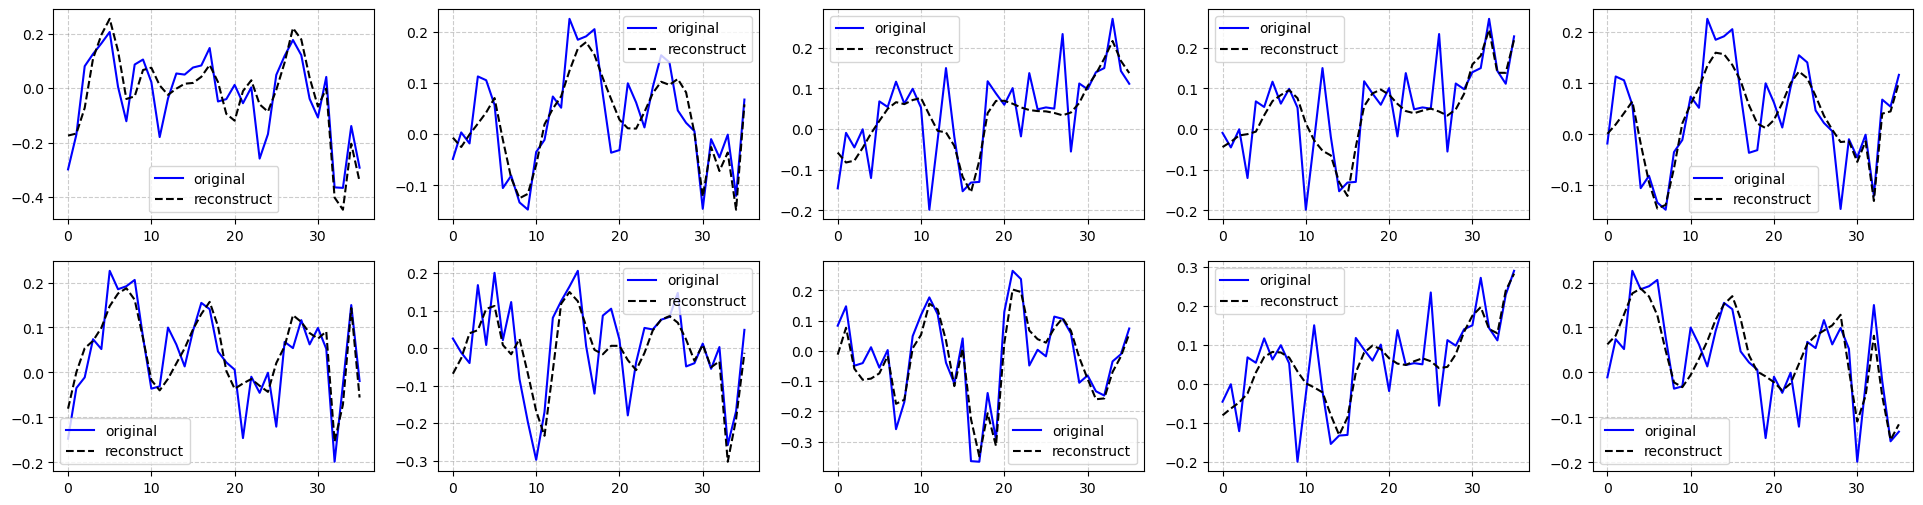

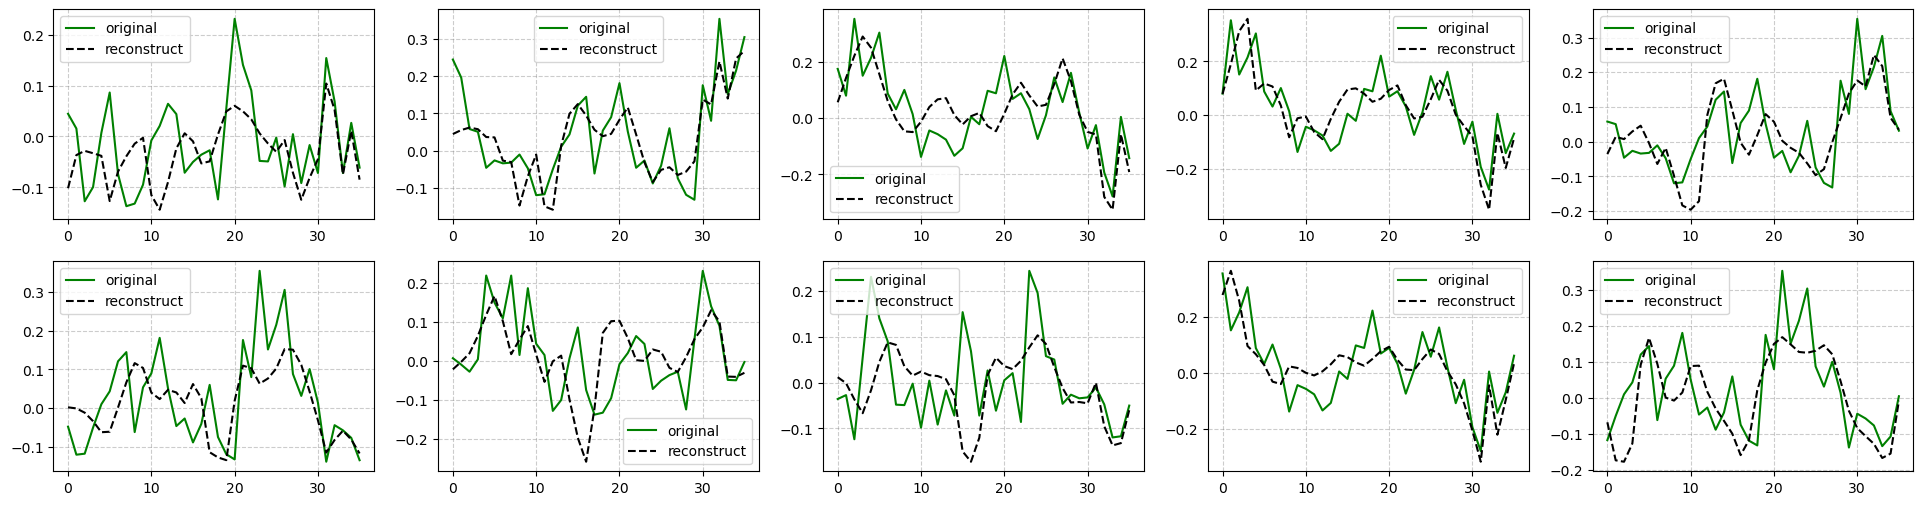

In [29]:
idxs = np.random.randint(0, 100, size = 10).tolist()
fig, axs = plt.subplots(2, 5, figsize = (24, 6))
x_hat = model(x)[:, :, 0:1]
for i, idx  in enumerate(idxs):
    axs[i//5][i%5].plot(x[idx, :, 0].detach().cpu(), color = "blue", label = "original")
    axs[i//5][i%5].plot(x_hat[idx].detach().cpu(), color = "black", label = "reconstruct", linestyle = '--')
    axs[i//5][i%5].grid(linestyle = '--', color = 'gray', alpha = .4)
    axs[i//5][i%5].legend()
fig.show()

idx = np.random.randint(0, 100, size = 10).tolist()
val_x_hat = model(val_x)[:, :, 0:1]
fig, axs = plt.subplots(2, 5, figsize = (24, 6))
for i, idx  in enumerate(idxs):
    axs[i//5][i%5].plot(val_x[idx, :, 0].detach().cpu(), color = "green", label = "original")
    axs[i//5][i%5].plot(val_x_hat[idx].detach().cpu(), color = "black", label = "reconstruct", linestyle = '--')
    axs[i//5][i%5].grid(linestyle = '--', color = 'gray', alpha = .4)
    axs[i//5][i%5].legend()
fig.show()

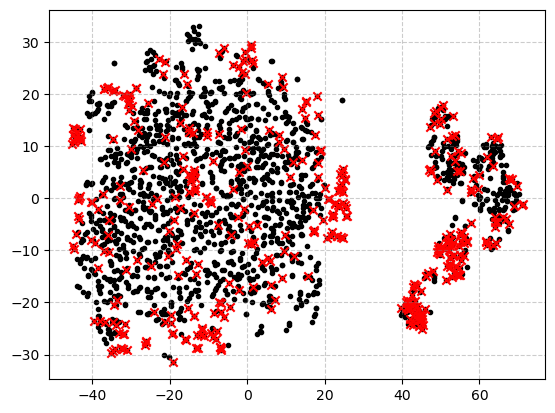

In [30]:
from sklearn.manifold import TSNE
dots = model.encoder(x)[0].squeeze()
dots = torch.cat([dots, model.encoder(val_x)[0].squeeze()])

tsne = TSNE(n_components=2)
dots_tsne = tsne.fit_transform(dots.detach().cpu())

plt.scatter(dots_tsne[:x.shape[0], 0], dots_tsne[:x.shape[0], 1], color = "black", marker = ".")
plt.scatter(dots_tsne[x.shape[0]:, 0], dots_tsne[x.shape[0]:, 1], color = "black", marker = ".")
plt.scatter(dots_tsne[500: 700, 0], dots_tsne[500: 700, 1], color = "red", marker = "x")
plt.scatter(dots_tsne[x.shape[0] + 500: x.shape[0] + 700, 0], dots_tsne[x.shape[0] + 500: x.shape[0] + 700, 1], color = "red", marker = "x")
plt.grid(linestyle = "--", color = 'gray', alpha = .4)
plt.show()


In [33]:
visualization = torch.tensor(preprocessing(arr[450:750], seq_length, win_size)).to(torch.float32).to(device = "cuda")
tsne = TSNE(n_components=2)
dots_tsne = tsne.fit_transform(model.encoder(visualization)[0].squeeze().detach().cpu())

MovieWriter ffmpeg unavailable; using Pillow instead.


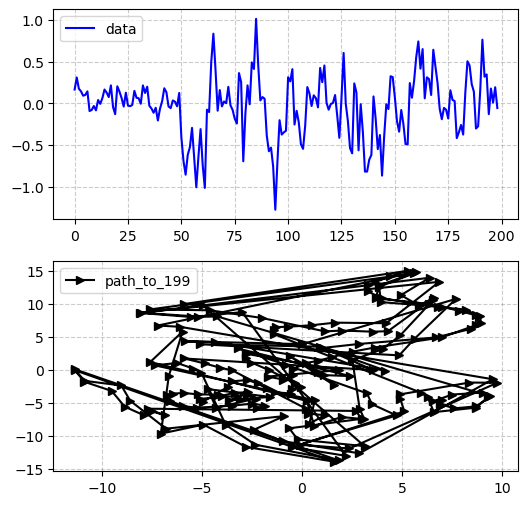

In [93]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(2, 1, figsize = (6, 6))
ax[0].set_xlim(0, dots_tsne.shape[0])
ax[0].set_ylim(-1.2, 1.2)
ax[1].set_xlim(-15, 15)     # 設定 x 軸範圍 0～10
ax[1].set_ylim(-16, 16)         # 設定 y 軸範圍 0～10

def init():
    pass

def run(idx):
    ax[0].clear()
    ax[0].plot(arr[450:450+idx],color = "blue", label = "data")
    ax[0].grid(linestyle = "--", color = "gray", alpha = .4)
    ax[0].legend()
    ax[1].clear()
    ax[1].plot(dots_tsne[:idx, 0], dots_tsne[:idx, 1], color = "black", label = f"path_to_{idx}", marker = ">")
    ax[1].grid(linestyle = "--", color = "gray", alpha = .4)
    ax[1].legend()

ani = animation.FuncAnimation(fig, run, frames=200, interval=dots_tsne.shape[0], init_func=init)  # 製作動畫
ani.save('animation.gif', fps=10)   # 儲存為 gif
plt.show()